In [1]:
import glob
print(glob.glob("/share/*"))

['/share/input.txt', '/share/us-stock-dataset', '/share/Transformers1']


In [2]:
import sys
import os

import torch
from torch import nn as nn
import glob

from t4.timeseries_transformer import TransformerConfig, TransformerRunner

from timeseries.csv_reader import read_and_merge_csv_files

from t3_karpathy.commons.commons import BaseTransformerConfig, min_max_scaling, extract_sliding_windows, z_scale
from t3_karpathy.token_codec import TokenCodec
from t4.generic_dataloader import GenericDataloader
from timeseries.timeseries_transformer import TimeseriesDataloader



In [3]:
stocks_to_load = [
    "AAPL", "TSLA",
    "A", "GOOG", "AMZN", "PYPL", "NVDA", "AMD",
    "NFLX", "MSFT", "INTC", "CSCO", "ADBE", "CRM", "QCOM", "TXN", "AVGO",
    "INTU", "ORCL", "COST", "SBUX", "AMGN", "CHTR", "GILD", "CMCSA", "BKNG",
    "MDLZ", "FISV", "BIIB", "MU", "MCD", "AMAT", "ADP", "ILMN", "ATVI", "ISRG",
    "ADSK", "LRCX", "BIDU", "JD", "REGN", "WBA", "VRTX", "KHC", "WMT", "ZM", "MELI",
    "TMUS", "CTSH", "XLNX", "PCAR", "ALGN", "WDAY", "SIRI", "CTXS", "ADI", "EXC", "LULU",
    "MAR", "KLAC", "PAYX", "EA", "ILMN", "ALXN", "MNST", "BMRN", "EBAY", "CTAS", "VRSK",
    "IDXX", "CDNS", "NXPI", "ASML", "INCY", "KLAC", "MCHP", "SNPS", "SWKS", "VRSN",
    "WDC", "WYNN", "XLNX", "ZBRA", "ZTS", "AEP", "AIG", "ALL", "AXP", "BA", "BAC",
    "BK", "BLK", "C", "CAT", "CL", "COF", "COP", "COST", "CSCO", "CVS", "CVX",
    "DD", "DHR", "DIS", "DOW", "DUK", "EMR", "EXC", "F", "FDX", "GD", "GE", "GILD",
    "GM", "GOOG", "GOOGL", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KHC", "KMI",
    "KO", "LLY", "LMT", "LOW", "MA", "MCD", "MDLZ", "MDT", "MET", "MMM",
    'BLND', 'BLNG', 'BLNKW', 'BLNGU', 'BLNGW', 'BLNK', 'BLPH', 'BLRX',
    'BLTE', 'BLU', 'BLUA', 'BLUE', 'BLW', 'BLX', 'BLZE', 'BMA', 'BMAC', 'BMAQ', 'BMAQR', 'BMAQU'
]

directory_path = '/share/us-stock-dataset/Data/Stocks'

# stocks_to_load = [s.split("\\")[1].replace(".csv", "") for s in glob.glob(directory_path + "//*.csv")]
#
# stock_number_to_load = 200
#
# stocks_to_load = stocks_to_load[1000:1000+stock_number_to_load]

dataloader = TimeseriesDataloader(directory_path, stocks_to_load, add_diff=False)

print(dataloader.get_data().shape)

Reading and merging CSV files: ['AAPL', 'TSLA', 'A', 'GOOG', 'AMZN', 'PYPL', 'NVDA', 'AMD', 'NFLX', 'MSFT', 'INTC', 'CSCO', 'ADBE', 'CRM', 'QCOM', 'TXN', 'AVGO', 'INTU', 'ORCL', 'COST', 'SBUX', 'AMGN', 'CHTR', 'GILD', 'CMCSA', 'BKNG', 'MDLZ', 'FISV', 'BIIB', 'MU', 'MCD', 'AMAT', 'ADP', 'ILMN', 'ATVI', 'ISRG', 'ADSK', 'LRCX', 'BIDU', 'JD', 'REGN', 'WBA', 'VRTX', 'KHC', 'WMT', 'ZM', 'MELI', 'TMUS', 'CTSH', 'XLNX', 'PCAR', 'ALGN', 'WDAY', 'SIRI', 'CTXS', 'ADI', 'EXC', 'LULU', 'MAR', 'KLAC', 'PAYX', 'EA', 'ILMN', 'ALXN', 'MNST', 'BMRN', 'EBAY', 'CTAS', 'VRSK', 'IDXX', 'CDNS', 'NXPI', 'ASML', 'INCY', 'KLAC', 'MCHP', 'SNPS', 'SWKS', 'VRSN', 'WDC', 'WYNN', 'XLNX', 'ZBRA', 'ZTS', 'AEP', 'AIG', 'ALL', 'AXP', 'BA', 'BAC', 'BK', 'BLK', 'C', 'CAT', 'CL', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'CVX', 'DD', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'EXC', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KHC', 'KMI', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD'

In [5]:
data_loader_data = dataloader.get_data().transpose(0, 1)
print(data_loader_data.shape)

torch.Size([145, 5283])


In [11]:
data = z_scale(data_loader_data, 1)

In [12]:
torch.std(data[1])

tensor(1.0000, device='cuda:0')

In [13]:
windowed = extract_sliding_windows(data, 8)
windowed.shape

torch.Size([145, 5276, 8])

In [14]:
windowed[0, 1, :]

tensor([-0.7169, -0.7164, -0.7193, -0.7178, -0.7184, -0.7200, -0.7219, -0.7187],
       device='cuda:0')

In [15]:
data[0,:]

tensor([-0.7138, -0.7169, -0.7164,  ...,  5.0451,  4.9679,  4.9192],
       device='cuda:0')

In [16]:
flat_windowed = windowed.reshape(windowed.shape[0]* windowed.shape[1], -1)
print(flat_windowed.shape)

torch.Size([765020, 8])


In [17]:
device = 'cuda'

torch.manual_seed(1337)

config = TransformerConfig(
    input_embed=flat_windowed.shape[1], 
    precision=torch.bfloat16, 
    batch_size=128, 
    block_size=1, 
    n_embed=64, 
    n_head=4, 
    n_layer=4, 
    learning_rate=0.001
)

runner = TransformerRunner(config, flat_windowed)

runner.train_iterate_n(25000)

context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(dataloader.token_codec.decode(runner.generate(context, max_new_tokens=2000)[0].tolist()))

0.404104 M parameters
step 0: train loss 1.2301, val loss 36.9868, time/iter 3.0994415283203126e-08
saved model version 1
step 100: train loss 0.0931, val loss 34.7678, time/iter 0.032638626098632814
step 200: train loss 0.1045, val loss 34.9991, time/iter 0.03430454015731812
step 300: train loss 0.0819, val loss 34.2777, time/iter 0.03449687719345093
step 400: train loss 0.0825, val loss 34.2914, time/iter 0.035138561725616455
step 500: train loss 0.1285, val loss 34.3025, time/iter 0.03449706315994263
step 600: train loss 0.0717, val loss 32.6144, time/iter 0.033883421421051024
step 700: train loss 0.0943, val loss 33.3575, time/iter 0.035076310634613035
step 800: train loss 0.0977, val loss 33.8370, time/iter 0.03378878355026245
step 900: train loss 0.0753, val loss 33.2797, time/iter 0.033210315704345704
step 1000: train loss 0.0641, val loss 32.9381, time/iter 0.03389265775680542
saved model version 2
step 1100: train loss 0.0578, val loss 32.8637, time/iter 0.033627846240997315
s

KeyboardInterrupt: 

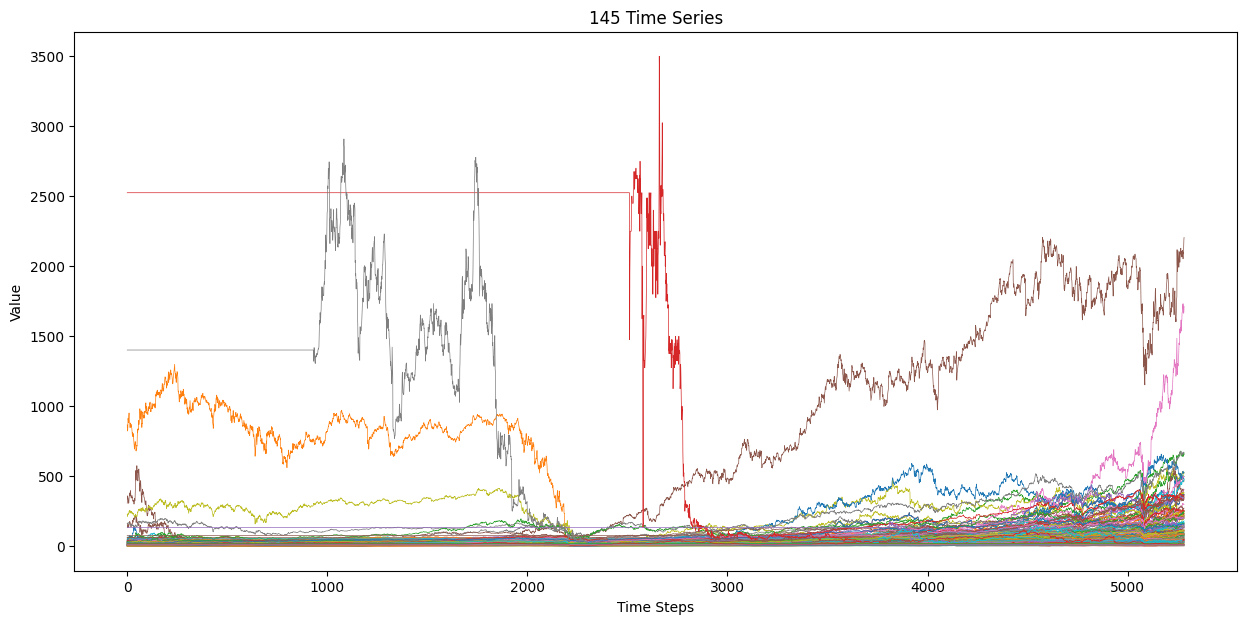

In [20]:
import torch
import matplotlib.pyplot as plt

# Generate a sample tensor (you can replace this with your tensor)
tensor = data_loader_data.to('cpu')

# Plotting
plt.figure(figsize=(15, 7))
for i in range(tensor.shape[0]):
    plt.plot(tensor[i].numpy(), linewidth=0.5)  # Convert tensor to numpy for plotting

plt.title("145 Time Series")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()
